In [1]:
#!unzip Images.zip

In [2]:
#!unzip Airplanes_Annotations.zip

In [3]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
path = "Images"

The general ideia of how the will it proccess 

correct_label6.png


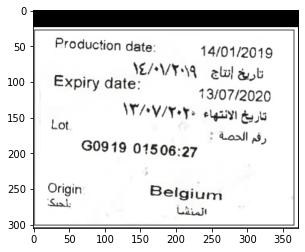

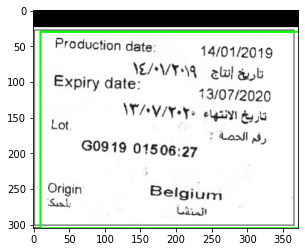

In [5]:
for e,i in enumerate(os.listdir(path)):
    if e < 10:
        filename = i.split(".")[0]+".png"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        #df = pd.read_csv(os.path.join(annot,i))
        height, width, channels = img.shape
        plt.imshow(img)
        #for row in df.iterrows():
            #x1 = int(row[1][0].split(" ")[0])
            #y1 = int(row[1][0].split(" ")[1])
            #x2 = int(row[1][0].split(" ")[2])
            #y2 = int(row[1][0].split(" ")[3])
        x1 = 10
        x2 = width
        y1 = 30
        y2 = height
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [6]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

The Ideia of what is algorithm of how is the algorithm is going to process the image

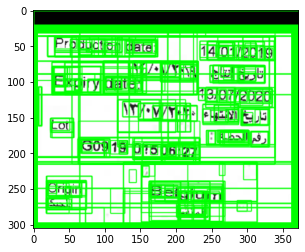

In [7]:
im = cv2.imread(os.path.join(path,"correct_label6.png"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [8]:
train_images=[]
train_labels=[]

In [9]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [10]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [11]:
for e,i in enumerate(os.listdir(path)):
    try:
        if i.startswith("label"):
            filename = i.split(".")[0]+".png"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            height, width, channels = image.shape
            #print(height, width, channels)               
            #df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            #for row in df.iterrows():
                #x1 = int(row[1][0].split(" ")[0])
                #y1 = int(row[1][0].split(" ")[1])
                #x2 = int(row[1][0].split(" ")[2])
                #y2 = int(row[1][0].split(" ")[3])
            x1 = 10
            x2 = width
            y1 = 30
            y2 = height
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            for e,result in enumerate(ssresults):
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        if filename.endswith('wrong.png'):
                            train_labels.append(1)
                        else:
                            train_labels.append(0)


    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

1 label2.png
2 label7.png
3 label9.png
4 label8.png
5 label5.png
6 label3.png
7 label4.png
8 label10.png
9 label1.png
10 label6.png
11 label12_wrong.png
12 label11_wrong.png


In [12]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [13]:
X_new.shape

(4921, 224, 224, 3)

In [14]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [15]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [17]:
X= vggmodel.layers[-2].output

In [18]:
predictions = Dense(2, activation="softmax")(X)

In [19]:
model_final = Model(vggmodel.input,predictions)

In [20]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [21]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [22]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [24]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [25]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [26]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [27]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4428, 224, 224, 3) (493, 224, 224, 3) (4428, 2) (493, 2)


In [28]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [31]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 6, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/home/duarte/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
6/6 [==============================] - 231s 37s/step - loss: 2.9582 - accuracy: 0.5606 - val_loss: 1.1190 - val_accuracy: 0.4062

Epoch 00001: val_loss improved from inf to 1.11900, saving model to ieeercnn_vgg16_1.h5
Epoch 2/5
6/6 [==============================] - 212s 37s/step - loss: 0.8273 - accuracy: 0.6485 - val_loss: 0.7345 - val_accuracy: 0.8594

Epoch 00002: val_loss improved from 1.11900 to 0.73447, saving model to ieeercnn_vgg16_1.h5
Epoch 3/5
6/6 [==============================] - 212s 37s/step - loss: 0.6278 - accuracy: 0.8503 - val_loss: 0.5397 - val_accuracy: 0.7188

Epoch 00003: val_loss improved from 0.73447 to 0.53970, saving model to ieeercnn_vgg16_1.h5
Epoch 4/5
6/6 [==============================] - 222s 39s/step - loss: 0.5916 - accuracy: 0.7561 - val_loss: 0.5198 - val_accuracy: 0.7969

Epoch 00004: val_loss improved from 0.53970 to 0.51978, saving model to ieeercnn_vgg16_1.h5
Epoch 5/5
6/6 [==============================] - 241s 43s/step - loss: 0.397

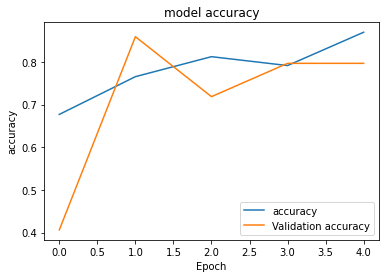

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["accuracy","Validation accuracy"])
plt.show()
plt.savefig('chart accuracy')


In [33]:
X_test.shape

(493, 224, 224, 3)

not label


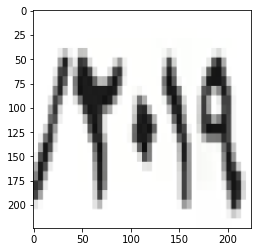

In [34]:
im = X_test[7]
img = np.expand_dims(im, axis=0)
plt.imshow(im)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("label")
    plt.imshow(out)
else:
    print("not label")
    

Will only consider the images detected with 80% of accoracy 

0.9191556249487672


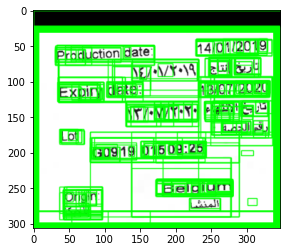

In [44]:
for e,i in enumerate(os.listdir(path)):
    if i=="label3.png":
        z=0
        total=0
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        flag_label_true = 0
        for e,result in enumerate(ssresults):
            z += 1
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][1] > 0.80:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    total+= out[0][1]
        print(total/z)
        if total/z > 0.85:
            plt.figure()
            plt.imshow(imout)